
# Boston example



### We illustrate bagging, random forests and boosting for the Boston housing data.  The material in this notebook is largely the same as Section 8.3 in your textbook, and in the notebook found here

https://github.com/intro-stat-learning/ISLP_labs/blob/stable/Ch08-baggboost-lab.ipynb

First, import some libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)

We will start by loading the data.

In [6]:
Boston = pd.read_csv('BostonHousing.csv',index_col=False)
Boston.head()
feature_names=list(Boston.columns[:-1])
X = Boston[feature_names]

First, we split the data into training and test sets, and fit the tree
to the training data. Here we use 30% of the data for the test set.


In [7]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size=0.3,
                                random_state=0)


First we fit a regression tree, similar to last week.

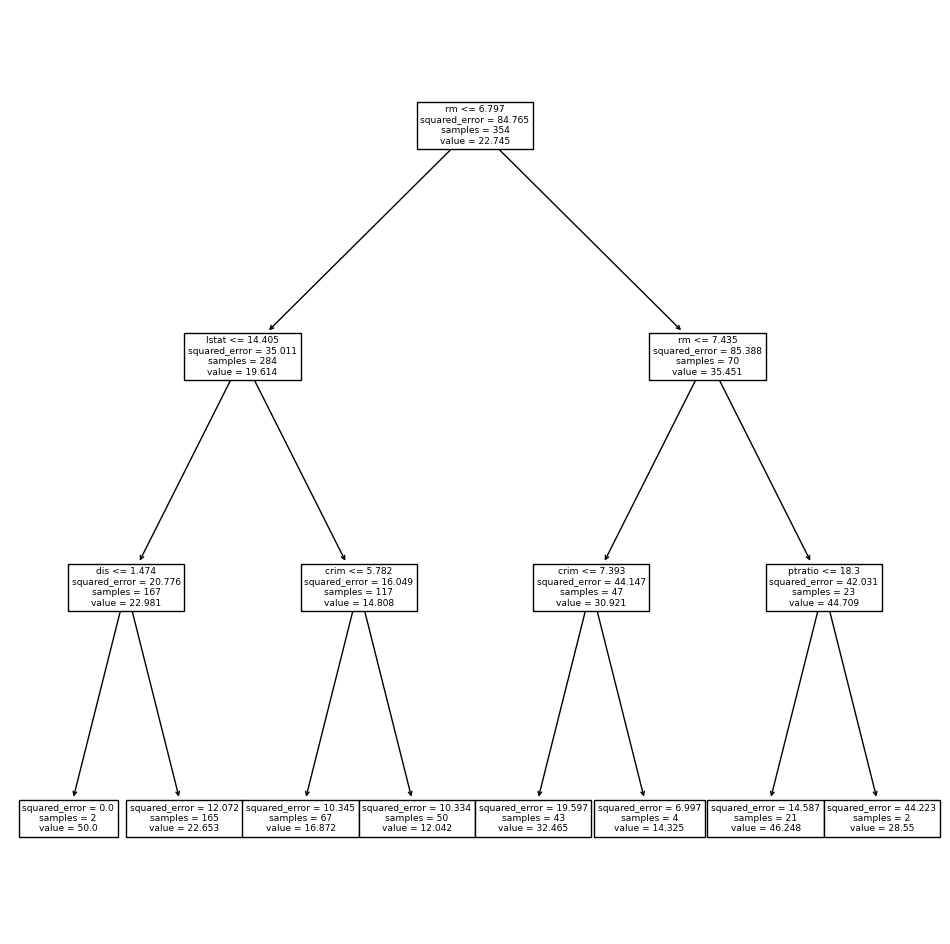

In [8]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);


Does pruning help to improve predictive performance on the test set?

In [9]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)


In [22]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)


28.06985754975404

Plot the tree.  Here the pruned tree is the same as the original tree.  

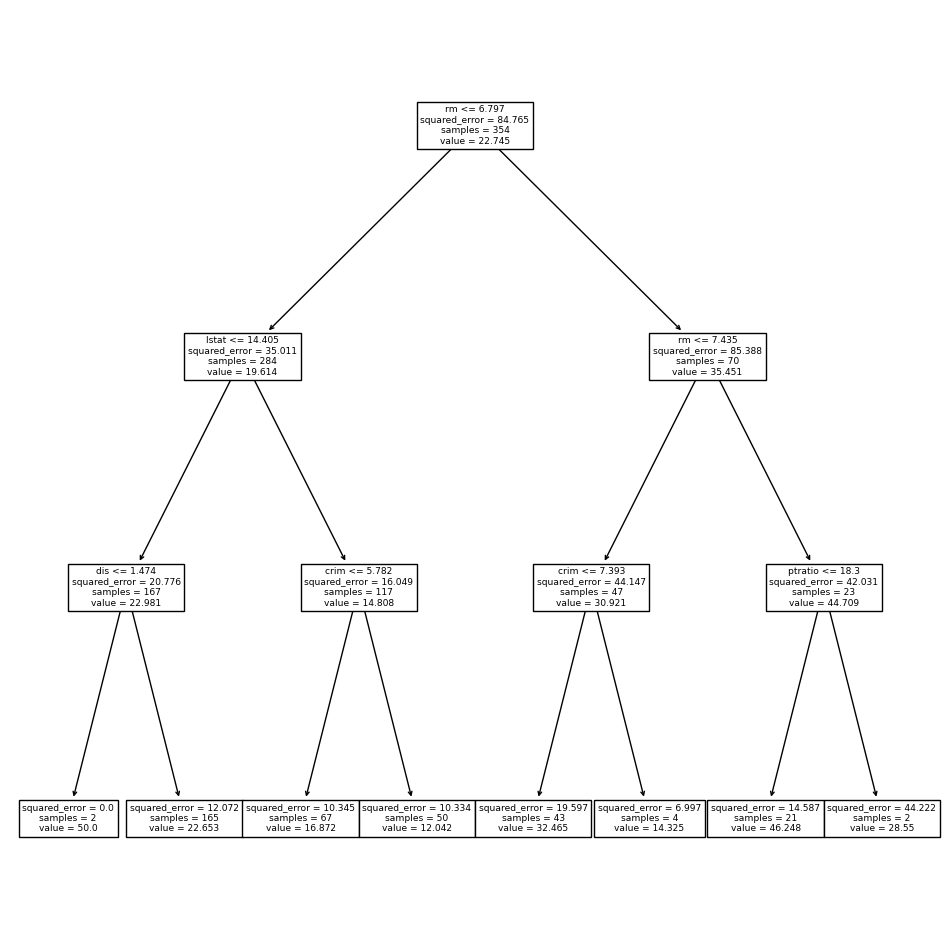

In [23]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);


## Bagging

Next we try bagging.  We can use a random forests regressor, setting the number of features to consider at each split to the total number of features.  Bagging and random forests are the same in this case.

In [25]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train);


What is the test set performance?

14.497125473684216

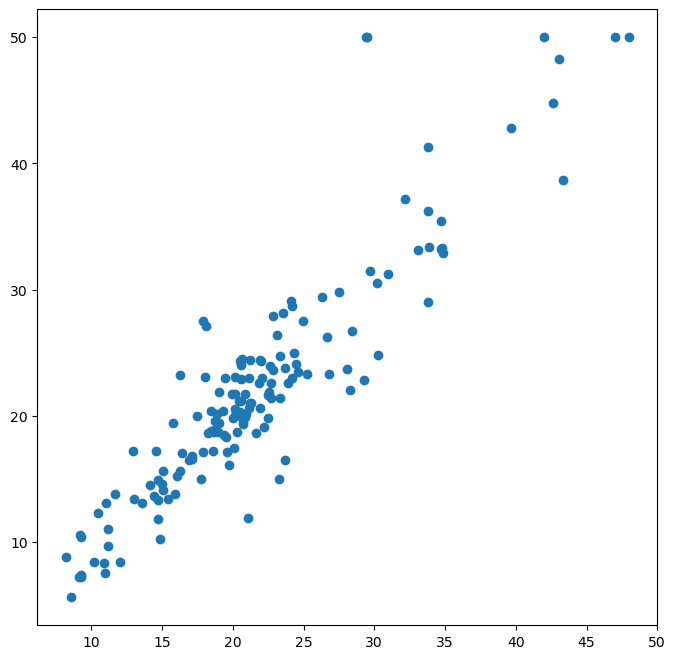

In [26]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)


The test set MSE is about half what we had for the pruned tree.  We can change B in bagging 
using the `n_estimators` argument.  Let's try B=500.

In [27]:
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.635974985789463

Let's try random forests with `max_features=6`.

In [28]:
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)


17.303834427631585

Bagging is slightly better here.  Next, look at feature importance.  

In [29]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.339597
rm,0.317068
ptratio,0.076850
indus,0.061168
crim,0.048062
dis,0.047143
nox,0.034380
tax,0.026831
age,0.023531
b,0.014786


The wealth level of the community (`lstat`) and the
house size (`rm`) are the two most important variables.

  

## Boosting

Now do boosting, with max_depth=3 for the trees of the ensemble, 
B=5000 and $\lambda=0.001$.

In [30]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train);


We can see how the training error decreases over the boosting
iterations using the `train_score_` attribute.
To get an idea of how the test error decreases we can use the
`staged_predict()` method to get the predicted values along the path.

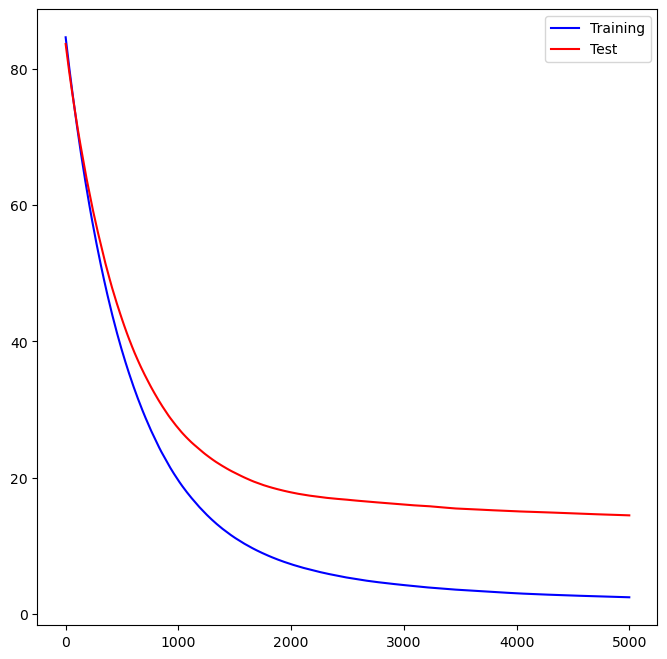

In [31]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();


Predictive performance on the test set:

In [32]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


14.482728749286935

What happens when we change $\lambda$?  Try $\lambda=0.2$.

In [33]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


13.121320458182673

In this case, using $\lambda=0.2$ leads to a almost the same test MSE
as when using $\lambda=0.001$.

 